In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import pathlib
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mmichelli/cirrus-cumulus-stratus-nimbus-ccsn-database")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/cirrus-cumulus-stratus-nimbus-ccsn-database


In [3]:
import pathlib
import os

# Set the data directory path
data_dir = pathlib.Path('/kaggle/input/cirrus-cumulus-stratus-nimbus-ccsn-database/CCSN_v2')

# Get list of class names (subdirectories)
class_names = [d.name for d in data_dir.iterdir() if d.is_dir()]
print("Class names/labels:", class_names)

# Count total number of images
total_images = 0
for class_name in class_names:
    class_dir = data_dir / class_name
    num_images = len([f for f in class_dir.glob('*.jpg')]) + \
                 len([f for f in class_dir.glob('*.png')]) + \
                 len([f for f in class_dir.glob('*.jpeg')])
    print(f"Number of images in {class_name}: {num_images}")
    total_images += num_images

print(f"Total number of images: {total_images}")

Class names/labels: ['Cu', 'Sc', 'Ci', 'As', 'Ac', 'Ct', 'Cb', 'Cc', 'Ns', 'St', 'Cs']
Number of images in Cu: 182
Number of images in Sc: 340
Number of images in Ci: 139
Number of images in As: 188
Number of images in Ac: 221
Number of images in Ct: 200
Number of images in Cb: 242
Number of images in Cc: 268
Number of images in Ns: 274
Number of images in St: 202
Number of images in Cs: 287
Total number of images: 2543


In [4]:
import pathlib
import os
from PIL import Image, ImageEnhance
import random
import shutil

# Set paths
data_dir = pathlib.Path('/kaggle/input/cirrus-cumulus-stratus-nimbus-ccsn-database/CCSN_v2')
output_dir = pathlib.Path('/kaggle/working/augmented_clouds')  # Output directory for augmented images

# Create output directory if it doesn't exist
output_dir.mkdir(parents=True, exist_ok=True)

# Define class names
class_names = ['Cu', 'Sc', 'Ci', 'As', 'Ac', 'Ct', 'Cb', 'Cc', 'Ns', 'St', 'Cs']

# Function to apply augmentations and save images
def augment_and_save(image_path, output_class_dir, original_filename, num_augmented=5):
    try:
        # Load the original image
        img = Image.open(image_path).convert('RGB')
        
        # Create class output directory
        output_class_dir.mkdir(parents=True, exist_ok=True)
        
        # Save the original image
        img.save(output_class_dir / f"{original_filename}_orig.jpg")
        
        # Define augmentation functions using PIL
        augmentations = [
            lambda x: x.rotate(random.uniform(-30, 30)),  # Random rotation
            lambda x: x.transpose(Image.FLIP_LEFT_RIGHT),  # Horizontal flip
            lambda x: x.transpose(Image.FLIP_TOP_BOTTOM),  # Vertical flip
            lambda x: ImageEnhance.Brightness(x).enhance(random.uniform(0.5, 1.5)),  # Brightness
            lambda x: ImageEnhance.Color(x).enhance(random.uniform(0.5, 1.5))  # Color
        ]
        
        # Apply augmentations
        for i in range(num_augmented):
            aug_img = img.copy()  # Work on a copy of the original image
            
            # Randomly select 1-3 augmentations to combine
            num_transforms = random.randint(1, 3)
            selected_transforms = random.sample(augmentations, num_transforms)
            
            # Apply selected transformations
            for transform in selected_transforms:
                aug_img = transform(aug_img)
            
            # Save augmented image
            aug_filename = f"{original_filename}_aug_{i}.jpg"
            aug_img.save(output_class_dir / aug_filename)
    except Exception as e:
        print(f"Error processing {image_path}: {e}")

# Collect all image files across all classes at once
all_image_files = []
for class_name in class_names:
    class_dir = data_dir / class_name
    image_files = list(class_dir.glob('*.jpg')) + \
                  list(class_dir.glob('*.png')) + \
                  list(class_dir.glob('*.jpeg'))
    all_image_files.extend([(img_path, class_name) for img_path in image_files])

# Process all images at once
total_original = 0
total_augmented = 0

print(f"Found {len(all_image_files)} images across all classes. Starting augmentation...")

for img_path, class_name in all_image_files:
    filename = img_path.stem  # Get filename without extension
    output_class_dir = output_dir / class_name
    augment_and_save(img_path, output_class_dir, filename)
    total_original += 1
    total_augmented += 5  # 5 augmented versions per original

# Print summary
print(f"\nSummary:")
print(f"Total original images processed: {total_original}")
print(f"Total augmented images created: {total_augmented}")
print(f"Total images (original + augmented): {total_original + total_augmented}")

Found 2543 images across all classes. Starting augmentation...

Summary:
Total original images processed: 2543
Total augmented images created: 12715
Total images (original + augmented): 15258


In [5]:
import random
import numpy as np
import tensorflow as tf

# Set random seeds for reproducibility
random.seed(42)         # For Python's random module
np.random.seed(42)      # For NumPy
tf.random.set_seed(42)  # For TensorFlow

In [6]:
import pathlib
import os
import random
import shutil

# Paths (updated to match augmentation output)
preprocessed_dir = pathlib.Path('/kaggle/working/augmented_clouds')  # Changed from preprocessed_clouds
split_dir = pathlib.Path('/kaggle/working/split_dataset')
train_dir = split_dir / 'train'
val_dir = split_dir / 'val'
test_dir = split_dir / 'test'

# Create directories
for directory in [train_dir, val_dir, test_dir]:
    directory.mkdir(parents=True, exist_ok=True)

# Class names (same as augmentation code)
class_names = ['Cu', 'Sc', 'Ci', 'As', 'Ac', 'Ct', 'Cb', 'Cc', 'Ns', 'St', 'Cs']

# Split ratios
train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1

# Lists to track all images across splits
all_train_images = []
all_val_images = []
all_test_images = []

# Process each class
for class_name in class_names:
    class_dir = preprocessed_dir / class_name
    output_train_dir = train_dir / class_name
    output_val_dir = val_dir / class_name
    output_test_dir = test_dir / class_name
    
    # Create output directories
    output_train_dir.mkdir(parents=True, exist_ok=True)
    output_val_dir.mkdir(parents=True, exist_ok=True)
    output_test_dir.mkdir(parents=True, exist_ok=True)
    
    # Get all images for this class (include multiple extensions)
    images = list(class_dir.glob('*.jpg')) + \
             list(class_dir.glob('*.png')) + \
             list(class_dir.glob('*.jpeg'))
    random.shuffle(images)  # Shuffle to ensure randomness
    
    # Calculate split sizes
    total_images = len(images)
    if total_images == 0:
        print(f"Warning: No images found for class {class_name} in {class_dir}")
        continue
    
    train_size = int(total_images * train_ratio)
    val_size = int(total_images * val_ratio)
    test_size = total_images - train_size - val_size  # Ensure all images are used
    
    # Split the images
    train_images = images[:train_size]
    val_images = images[train_size:train_size + val_size]
    test_images = images[train_size + val_size:]
    
    # Copy images to respective directories and track totals
    for img in train_images:
        shutil.copy(img, output_train_dir / img.name)
        all_train_images.append(img)
    for img in val_images:
        shutil.copy(img, output_val_dir / img.name)
        all_val_images.append(img)
    for img in test_images:
        shutil.copy(img, output_test_dir / img.name)
        all_test_images.append(img)

# Print summary for the whole dataset
print("Dataset Split Summary:")
print(f"Total Training images: {len(all_train_images)}")
print(f"Total Validation images: {len(all_val_images)}")
print(f"Total Test images: {len(all_test_images)}")
print(f"Grand Total: {len(all_train_images) + len(all_val_images) + len(all_test_images)}")

Dataset Split Summary:
Total Training images: 10676
Total Validation images: 3047
Total Test images: 1535
Grand Total: 15258


In [10]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pathlib

# Set paths
split_dir = pathlib.Path('/kaggle/working/split_dataset')
train_dir = split_dir / 'train'
val_dir = split_dir / 'val'
test_dir = split_dir / 'test'

# Hyperparameters
batch_size = 32
learning_rate = 0.0001
dropout_rate = 0.2
num_epochs = 50  # Reduced to 50
num_classes = 11

# Data generators with MobileNetV2 preprocessing
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

val_test_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

# Load datasets
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Load MobileNetV2 pre-trained model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze first 1/3 of layers
total_layers = len(base_model.layers)
freeze_until = total_layers // 3
for layer in base_model.layers[:freeze_until]:
    layer.trainable = False

# Build the model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(dropout_rate),
    layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Model summary
model.summary()

# Train the model with EarlyStopping
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,  # 10676 // 32 = 333
    epochs=num_epochs,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,  # 3047 // 32 = 95
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint(
            'best_mobilenetv2_model.keras',
            monitor='val_accuracy',
            save_best_only=True,
            mode='max'
        ),
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=10,  # Stop if no improvement for 10 epochs
            mode='max',
            restore_best_weights=True
        )
    ]
)

# Evaluate on test set
best_model = tf.keras.models.load_model('best_mobilenetv2_model.keras')
test_loss, test_accuracy = best_model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Found 10676 images belonging to 11 classes.
Found 3047 images belonging to 11 classes.
Found 1535 images belonging to 11 classes.


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 11)                  │          14,091 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,272,075 (8.67 MB)

 Trainable params: 2,188,683 (8.35 MB)

 Non-trainable params: 83,392 (325.75 KB)

Epoch 1/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 56s 95ms/step - accuracy: 0.3356 - loss: 1.9459 - val_accuracy: 0.3684 - val_loss: 2.1703
Epoch 2/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.4062 - loss: 1.5761 - val_accuracy: 0.5714 - val_loss: 0.9861
Epoch 3/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 20s 58ms/step - accuracy: 0.6528 - loss: 1.0289 - val_accuracy: 0.4990 - val_loss: 1.4802
Epoch 4/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 102us/step - accuracy: 0.5000 - loss: 1.1280 - val_accuracy: 0.5714 - val_loss: 1.0910
Epoch 5/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 20s 58ms/step - accuracy: 0.8245 - loss: 0.5759 - val_accuracy: 0.5362 - val_loss: 1.4233
Epoch 6/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 89us/step - accuracy: 0.9375 - loss: 0.4317 - val_accuracy: 0.4286 - val_loss: 1.2161
Epoch 7/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 20s 58ms/step - accuracy: 0.9118 - loss: 0.3192 - val_accuracy: 0.5924 - val_loss: 1.2844
Epoch 8/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9375 - loss: 0.2203 - val_a

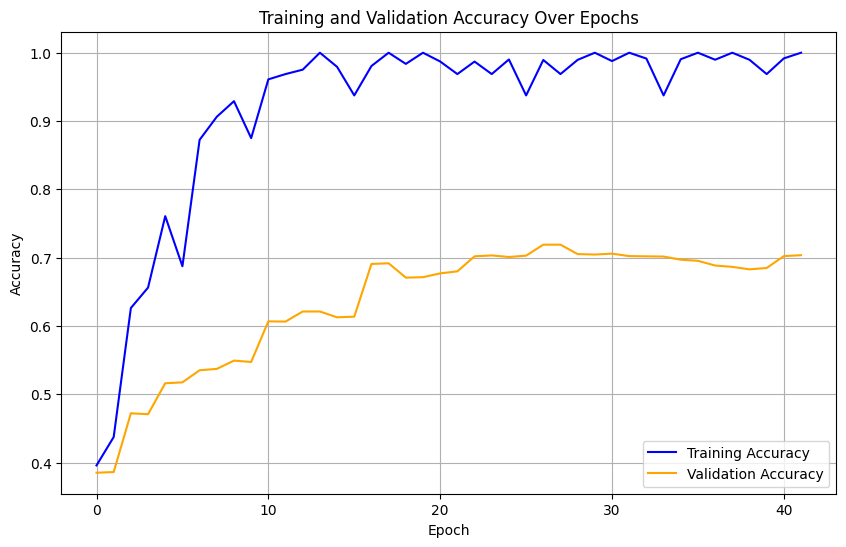

In [18]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

Found 10676 images belonging to 11 classes.
Found 3047 files belonging to 11 classes.
Found 1535 files belonging to 11 classes.


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_4           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 11)                  │          14,091 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,272,075 (8.67 MB)

 Trainable params: 1,870,347 (7.13 MB)

 Non-trainable params: 401,728 (1.53 MB)

Epoch 1/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 44s 81ms/step - accuracy: 0.3115 - loss: 2.2725 - val_accuracy: 0.3853 - val_loss: 2.4111
Epoch 2/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.4375 - loss: 1.6637 - val_accuracy: 0.3863 - val_loss: 2.4034
Epoch 3/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 17s 50ms/step - accuracy: 0.6217 - loss: 1.3451 - val_accuracy: 0.4723 - val_loss: 1.9018
Epoch 4/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6562 - loss: 1.1344 - val_accuracy: 0.4710 - val_loss: 1.9094
Epoch 5/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 16s 48ms/step - accuracy: 0.7613 - loss: 0.9388 - val_accuracy: 0.5162 - val_loss: 2.0084
Epoch 6/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.6875 - loss: 1.1467 - val_accuracy: 0.5176 - val_loss: 1.9974
Epoch 7/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.8816 - loss: 0.6197 - val_accuracy: 0.5353 - val_loss: 1.8625
Epoch 8/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9062 - loss: 0.5015 - val_accu

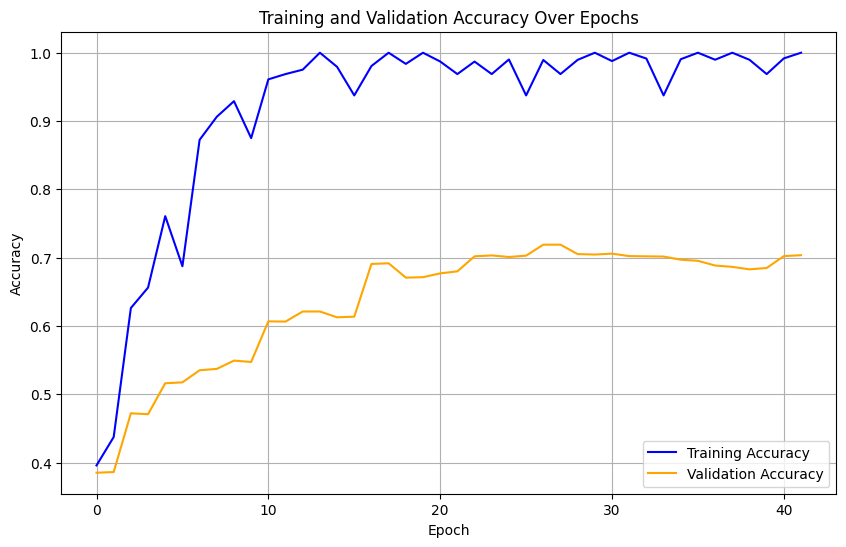

48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - accuracy: 0.6896 - loss: 1.2657
Test Loss: 1.1153, Test Accuracy: 0.7153


In [13]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pathlib
import matplotlib.pyplot as plt

# Set paths
split_dir = pathlib.Path('/kaggle/working/split_dataset')
train_dir = split_dir / 'train'
val_dir = split_dir / 'val'
test_dir = split_dir / 'test'

# Hyperparameters
batch_size = 32
learning_rate = 0.0001  # Reduced back to 0.0001
dropout_rate = 0.3
num_epochs = 50
num_classes = 11

# Data generators for training only
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

# Use tf.data.Dataset for validation and test to ensure consistent batches
val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    image_size=(224, 224),
    batch_size=batch_size,
    shuffle=False,
    label_mode='categorical'
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=(224, 224),
    batch_size=batch_size,
    shuffle=False,
    label_mode='categorical'
)

# Apply MobileNetV2 preprocessing to validation and test datasets
def preprocess(image, label):
    image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
    return image, label

val_dataset = val_dataset.map(preprocess).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.map(preprocess).prefetch(tf.data.AUTOTUNE)

# Load MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze first 2/3 of layers
total_layers = len(base_model.layers)
freeze_until = (2 * total_layers) // 3
for layer in base_model.layers[:freeze_until]:
    layer.trainable = False

# Build the model with L2 regularization
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(dropout_rate),
    layers.Dense(num_classes, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.01))
])

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Model summary
model.summary()

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=num_epochs,
    validation_data=val_dataset,
    # No validation_steps needed with tf.data.Dataset
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint(
            'best_mobilenetv2_model.keras',
            monitor='val_accuracy',
            save_best_only=True,
            mode='max'
        ),
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=15,
            mode='max',
            restore_best_weights=True
        )
    ]
)

# Plot accuracies
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Evaluate on test set
best_model = tf.keras.models.load_model('best_mobilenetv2_model.keras')
test_loss, test_accuracy = best_model.evaluate(test_dataset)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Found 10676 images belonging to 11 classes.
Found 3047 files belonging to 11 classes.
Found 1535 files belonging to 11 classes.


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 11)                  │          14,091 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,272,075 (8.67 MB)

 Trainable params: 2,188,683 (8.35 MB)

 Non-trainable params: 83,392 (325.75 KB)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


333/333 ━━━━━━━━━━━━━━━━━━━━ 178s 435ms/step - accuracy: 0.3082 - loss: 2.0352 - val_accuracy: 0.3384 - val_loss: 2.2759
Epoch 2/50
  1/333 ━━━━━━━━━━━━━━━━━━━━ 16s 49ms/step - accuracy: 0.4375 - loss: 1.5025

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


333/333 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4375 - loss: 1.5025 - val_accuracy: 0.3377 - val_loss: 2.2680
Epoch 3/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 129s 380ms/step - accuracy: 0.5386 - loss: 1.3358 - val_accuracy: 0.4161 - val_loss: 1.8025
Epoch 4/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5938 - loss: 1.2217 - val_accuracy: 0.4155 - val_loss: 1.8049
Epoch 5/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 130s 381ms/step - accuracy: 0.6284 - loss: 1.0708 - val_accuracy: 0.5310 - val_loss: 1.3830
Epoch 6/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.4688 - loss: 1.5339 - val_accuracy: 0.5330 - val_loss: 1.3810
Epoch 7/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 128s 377ms/step - accuracy: 0.6968 - loss: 0.8687 - val_accuracy: 0.5799 - val_loss: 1.2500
Epoch 8/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8438 - loss: 0.4723 - val_accuracy: 0.5770 - val_loss: 1.2625
Epoch 9/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 129s 380ms/step - accuracy: 0.7483 - loss: 0.7123 - val_accurac

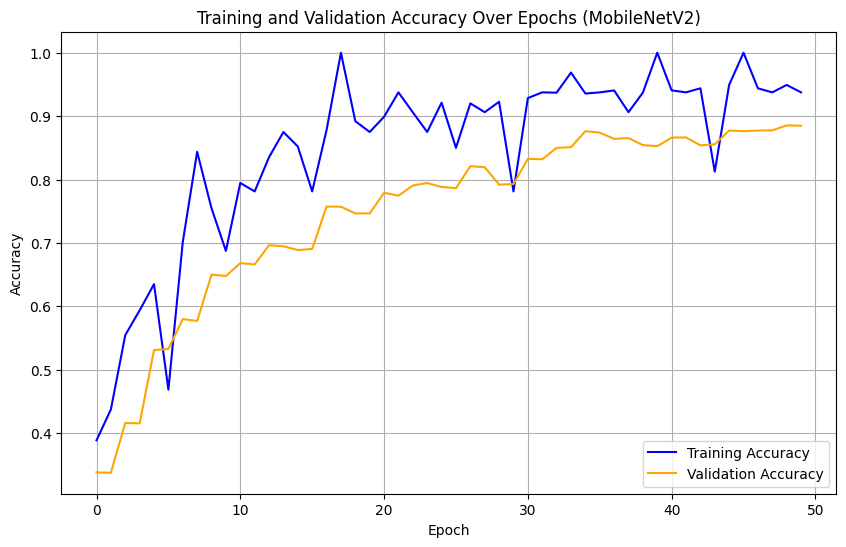

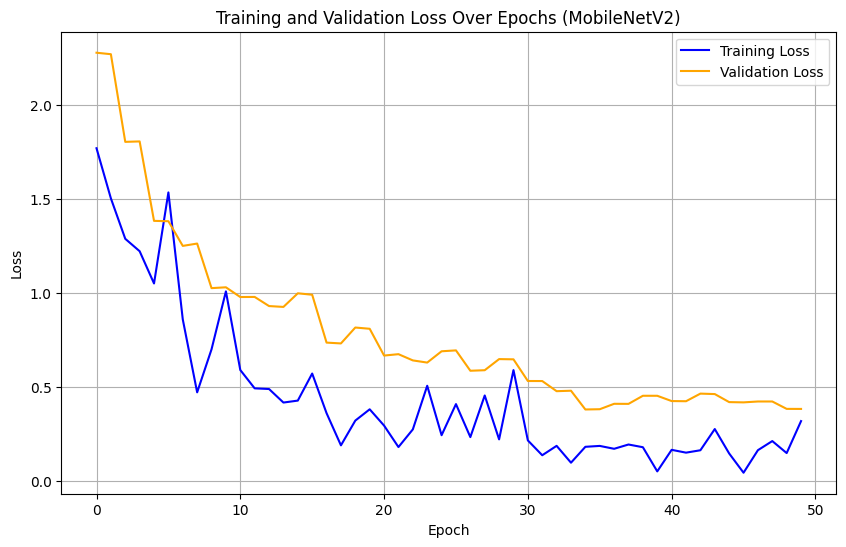

48/48 ━━━━━━━━━━━━━━━━━━━━ 7s 76ms/step - accuracy: 0.9023 - loss: 0.3164
Test Loss: 0.3617, Test Accuracy: 0.8893


In [17]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pathlib
import matplotlib.pyplot as plt

# Set paths
split_dir = pathlib.Path('/kaggle/working/split_dataset')
train_dir = split_dir / 'train'
val_dir = split_dir / 'val'
test_dir = split_dir / 'test'

# Hyperparameters (aligned with the paper)
batch_size = 32
learning_rate = 0.0001
dropout_rate = 0.2  
num_epochs = 50  
num_classes = 11

# Data generators with paper’s augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    rotation_range=20,          
    horizontal_flip=True,       # Paper: Flipping
    vertical_flip=True,         # Paper: Flipping
    brightness_range=[0.8, 1.2],# Paper: Brightness enhancement
    channel_shift_range=20.0    # Paper: Color enhancement (approximated)
)

# Validation and test data (no augmentation)
val_test_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

# Load training data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

# Use tf.data.Dataset for validation and test
val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    image_size=(224, 224),
    batch_size=batch_size,
    shuffle=False,
    label_mode='categorical'
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=(224, 224),
    batch_size=batch_size,
    shuffle=False,
    label_mode='categorical'
)

# Apply MobileNetV2 preprocessing
def preprocess(image, label):
    image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
    return image, label

val_dataset = val_dataset.map(preprocess).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.map(preprocess).prefetch(tf.data.AUTOTUNE)

# Load MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze first 1/3 of layers (as per the paper)
total_layers = len(base_model.layers)
freeze_until = total_layers // 3  # ~51 layers frozen
for layer in base_model.layers[:freeze_until]:
    layer.trainable = False

# Build the model (dropout matches paper, no L2 regularization)
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(dropout_rate),
    layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Model summary
model.summary()

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=num_epochs,
    validation_data=val_dataset,
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint(
            'best_mobilenetv2_model.keras',
            monitor='val_accuracy',
            save_best_only=True,
            mode='max'
        ),
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=20,
            mode='max',
            restore_best_weights=True
        )
    ]
)

# Plot accuracies
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Training and Validation Accuracy Over Epochs (MobileNetV2)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Plot losses
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Training and Validation Loss Over Epochs (MobileNetV2)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

# Evaluate on test set
best_model = tf.keras.models.load_model('best_mobilenetv2_model.keras')
test_loss, test_accuracy = best_model.evaluate(test_dataset)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

In [7]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pathlib

# Set paths
split_dir = pathlib.Path('/kaggle/working/split_dataset')
train_dir = split_dir / 'train'
val_dir = split_dir / 'val'
test_dir = split_dir / 'test'

# Hyperparameters
batch_size = 32
num_classes = 11

# Data generators with augmentation for training
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    rotation_range=20,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2],
    channel_shift_range=20.0
)

# Validation and test data (no augmentation)
val_test_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

# Load training data with augmentation
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

# Load validation data
val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Load test data
test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 10676 images belonging to 11 classes.
Found 3047 images belonging to 11 classes.
Found 1535 images belonging to 11 classes.


In [19]:

# Train the model (Phase 1: Train with frozen layers)
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=num_epochs // 2,  # First 50 epochs with frozen layers
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    class_weight=class_weights_dict,  # Use class weights
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint(
            'best_mobilenetv2_model_phase1.keras',
            monitor='val_accuracy',
            save_best_only=True,
            mode='max'
        ),
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=30,  # Increased patience
            mode='max',
            restore_best_weights=True
        )
    ]
)

# Fine-tuning (Phase 2: Unfreeze some layers and train with a smaller learning rate)
# Unfreeze the last 1/3 of layers
for layer in base_model.layers[freeze_until:]:
    layer.trainable = True

# Recompile with a smaller learning rate for fine-tuning
fine_tune_learning_rate = initial_learning_rate / 10  # Smaller learning rate for fine-tuning
model.compile(
    optimizer=tf.keras.optimizers.Adam(
        learning_rate=fine_tune_learning_rate,
        clipnorm=1.0
    ),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Continue training (Phase 2)
history_fine_tune = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=num_epochs // 2,  # Another 50 epochs for fine-tuning
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    class_weight=class_weights_dict,
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint(
            'best_mobilenetv2_model_phase2.keras',
            monitor='val_accuracy',
            save_best_only=True,
            mode='max'
        ),
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=30,
            mode='max',
            restore_best_weights=True
        )
    ]
)



Epoch 1/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 135s 399ms/step - accuracy: 0.8685 - loss: 0.5177 - val_accuracy: 0.7990 - val_loss: 0.7077
Epoch 2/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 90us/step - accuracy: 0.8750 - loss: 0.6263 - val_accuracy: 0.7143 - val_loss: 0.5495
Epoch 3/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 135s 398ms/step - accuracy: 0.8636 - loss: 0.5293 - val_accuracy: 0.8145 - val_loss: 0.6657
Epoch 4/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8438 - loss: 0.6488 - val_accuracy: 0.8571 - val_loss: 0.5056
Epoch 5/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 135s 398ms/step - accuracy: 0.8697 - loss: 0.5003 - val_accuracy: 0.8263 - val_loss: 0.6294
Epoch 6/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 72us/step - accuracy: 0.8750 - loss: 0.4798 - val_accuracy: 0.8571 - val_loss: 0.5700
Epoch 7/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 137s 405ms/step - accuracy: 0.8764 - loss: 0.4900 - val_accuracy: 0.8359 - val_loss: 0.6086
Epoch 8/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 89us/step - accuracy: 0.9062 - loss: 0.3881

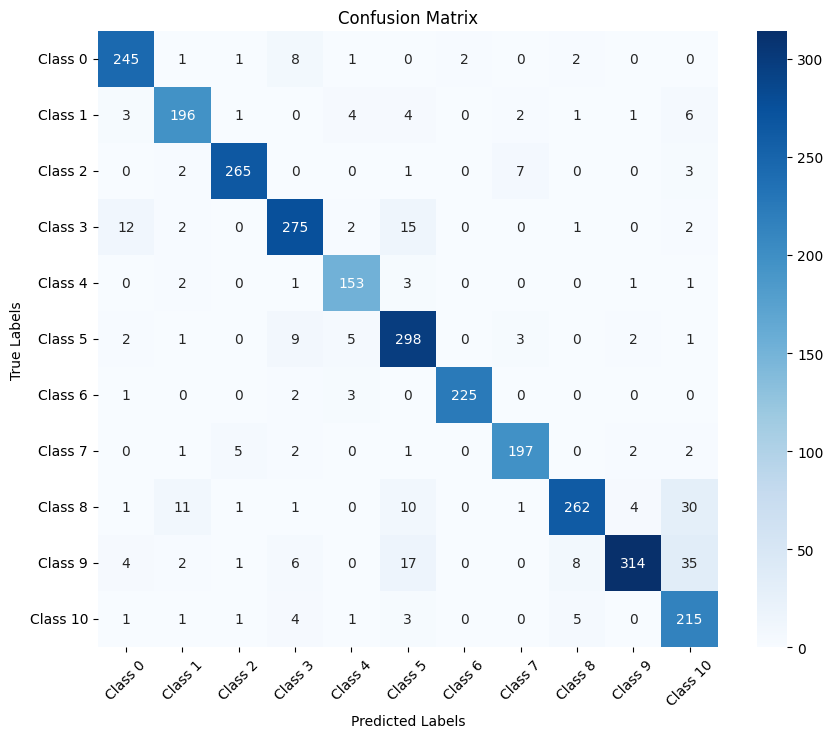

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Provided confusion matrix
cm = np.array([
    [245,   1,   1,   8,   1,   0,   2,   0,   2,   0,   0],
    [  3, 196,   1,   0,   4,   4,   0,   2,   1,   1,   6],
    [  0,   2, 265,   0,   0,   1,   0,   7,   0,   0,   3],
    [ 12,   2,   0, 275,   2,  15,   0,   0,   1,   0,   2],
    [  0,   2,   0,   1, 153,   3,   0,   0,   0,   1,   1],
    [  2,   1,   0,   9,   5, 298,   0,   3,   0,   2,   1],
    [  1,   0,   0,   2,   3,   0, 225,   0,   0,   0,   0],
    [  0,   1,   5,   2,   0,   1,   0, 197,   0,   2,   2],
    [  1,  11,   1,   1,   0,  10,   0,   1, 262,   4,  30],
    [  4,   2,   1,   6,   0,  17,   0,   0,   8, 314,  35],
    [  1,   1,   1,   4,   1,   3,   0,   0,   5,   0, 215]
])

# Define class labels (replace with your actual class names if needed)
class_labels = [f"Class {i}" for i in range(11)]

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()


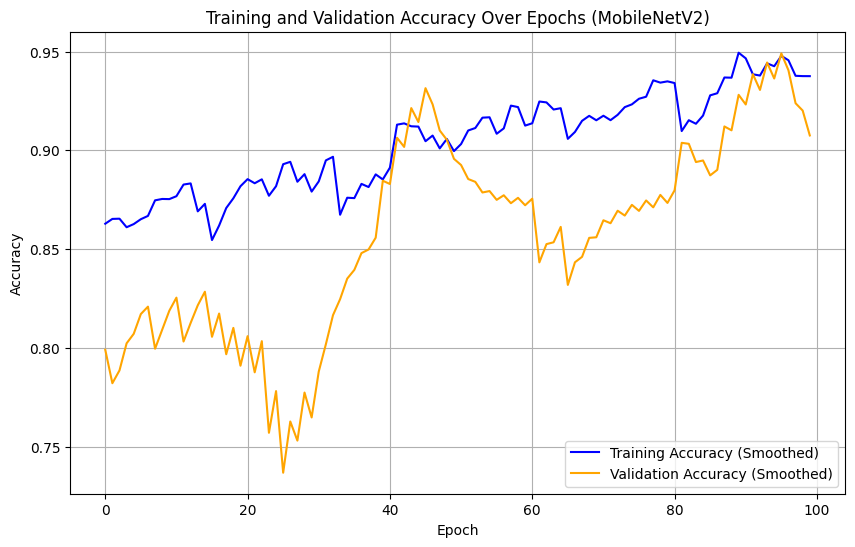

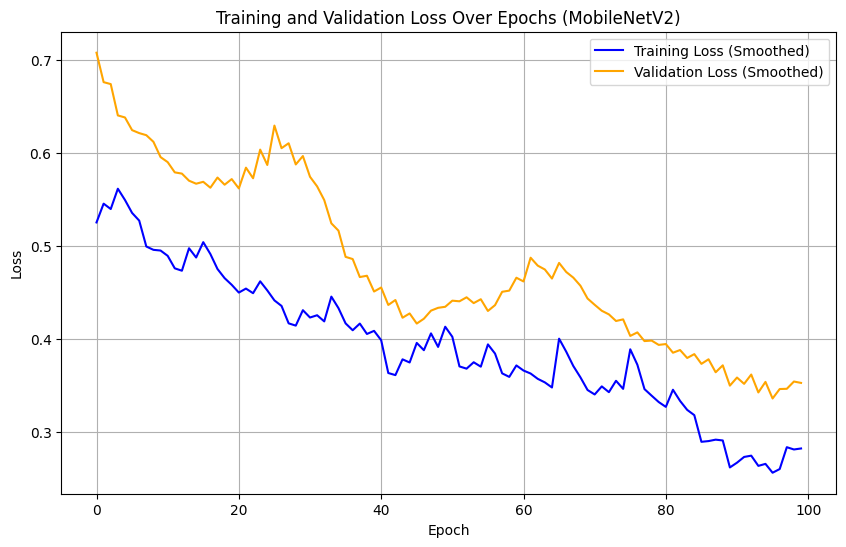

48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 115ms/step - accuracy: 0.8941 - loss: 0.4201
Test Loss: 0.4587, Test Accuracy: 0.8853
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 106ms/step
Classification Report:
              precision    recall  f1-score   support

          Ac       0.88      0.92      0.90       133
          As       0.92      0.85      0.89       114
          Cb       0.96      0.88      0.92       146
          Cc       0.85      0.91      0.88       162
          Ci       0.93      0.84      0.88        85
          Cs       0.88      0.87      0.87       173
          Ct       0.98      0.99      0.98       120
          Cu       0.87      0.90      0.88       110
          Ns       0.85      0.90      0.87       166
          Sc       0.92      0.83      0.87       204
          St       0.75      0.85      0.80       122

    accuracy                           0.89      1535
   macro avg       0.89      0.89      0.89      1535
weighted avg       0.89      0.89      0.89      1535

Confusi

In [20]:
# Combine histories for plotting
history_combined = {}
for key in history.history:
    history_combined[key] = history.history[key] + history_fine_tune.history[key]

# Function to smooth the curves for plotting
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points
# Plot smoothed accuracies
plt.figure(figsize=(10, 6))
plt.plot(smooth_curve(history_combined['accuracy']), label='Training Accuracy (Smoothed)', color='blue')
plt.plot(smooth_curve(history_combined['val_accuracy']), label='Validation Accuracy (Smoothed)', color='orange')
plt.title('Training and Validation Accuracy Over Epochs (MobileNetV2)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Plot smoothed losses
plt.figure(figsize=(10, 6))
plt.plot(smooth_curve(history_combined['loss']), label='Training Loss (Smoothed)', color='blue')
plt.plot(smooth_curve(history_combined['val_loss']), label='Validation Loss (Smoothed)', color='orange')
plt.title('Training and Validation Loss Over Epochs (MobileNetV2)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()
# Evaluate on test set
best_model = tf.keras.models.load_model('best_mobilenetv2_model_phase2.keras')
test_loss, test_accuracy = best_model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Generate classification report and confusion matrix
# Reset the test_generator to ensure it starts from the beginning
test_generator.reset()
y_pred = best_model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = test_generator.classes
class_names = list(test_generator.class_indices.keys())

print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=class_names))

print("Confusion Matrix:")
print(confusion_matrix(y_true_classes, y_pred_classes))

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ mobilenetv2_1.00_224      │ (None, 7, 7, 1280)     │      2,257,984 │ input_layer_1[0][0]    │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 1280)           │              0 │ mobilenetv2_1.00_224[… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 1280)           │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 128)            │        163,968 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 128)            │        163,968 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 128)            │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 128)            │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cloud_output (Dense)      │ (None, 11)             │          1,419 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rainfall_output (Dense)   │ (None, 3)              │            387 │ dropout_2[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,587,726 (9.87 MB)

 Trainable params: 2,504,334 (9.55 MB)

 Non-trainable params: 83,392 (325.75 KB)

Starting initial training...
Epoch 1/35
Found 10676 images belonging to 11 classes.
667/667 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - cloud_output_accuracy: 0.2467 - cloud_output_loss: 2.1752 - loss: 3.0700 - rainfall_output_accuracy: 0.6043 - rainfall_output_loss: 0.8949Found 3047 images belonging to 11 classes.

Epoch 1: val_rainfall_output_accuracy improved from -inf to 0.72336, saving model to best_mobilenetv2_dual.keras
667/667 ━━━━━━━━━━━━━━━━━━━━ 176s 214ms/step - cloud_output_accuracy: 0.2468 - cloud_output_loss: 2.1747 - loss: 3.0694 - rainfall_output_accuracy: 0.6044 - rainfall_output_loss: 0.8946 - val_cloud_output_accuracy: 0.3780 - val_cloud_output_loss: 1.8093 - val_loss: 2.5693 - val_rainfall_output_accuracy: 0.7234 - val_rainfall_output_loss: 0.7600
Epoch 2/35
667/667 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - cloud_output_accuracy: 0.4611 - cloud_output_loss: 1.5387 - loss: 2.0861 - rainfall_output_accuracy: 0.7735 - rainfall_output_loss: 0.5519
Epoch 2: val_rainfall_output_accur

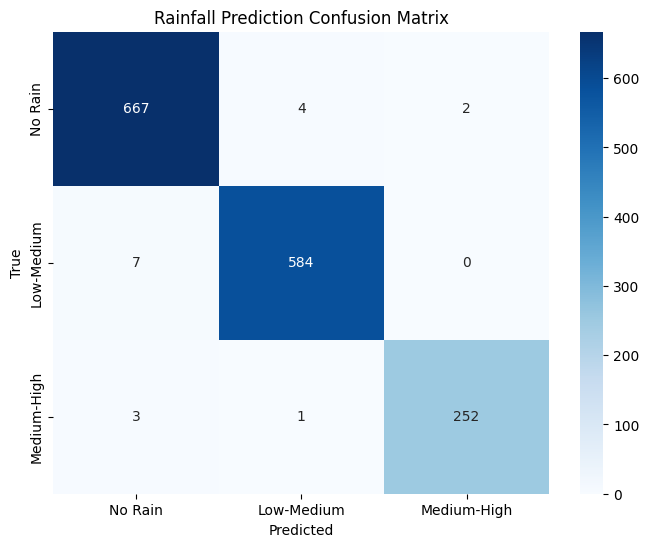

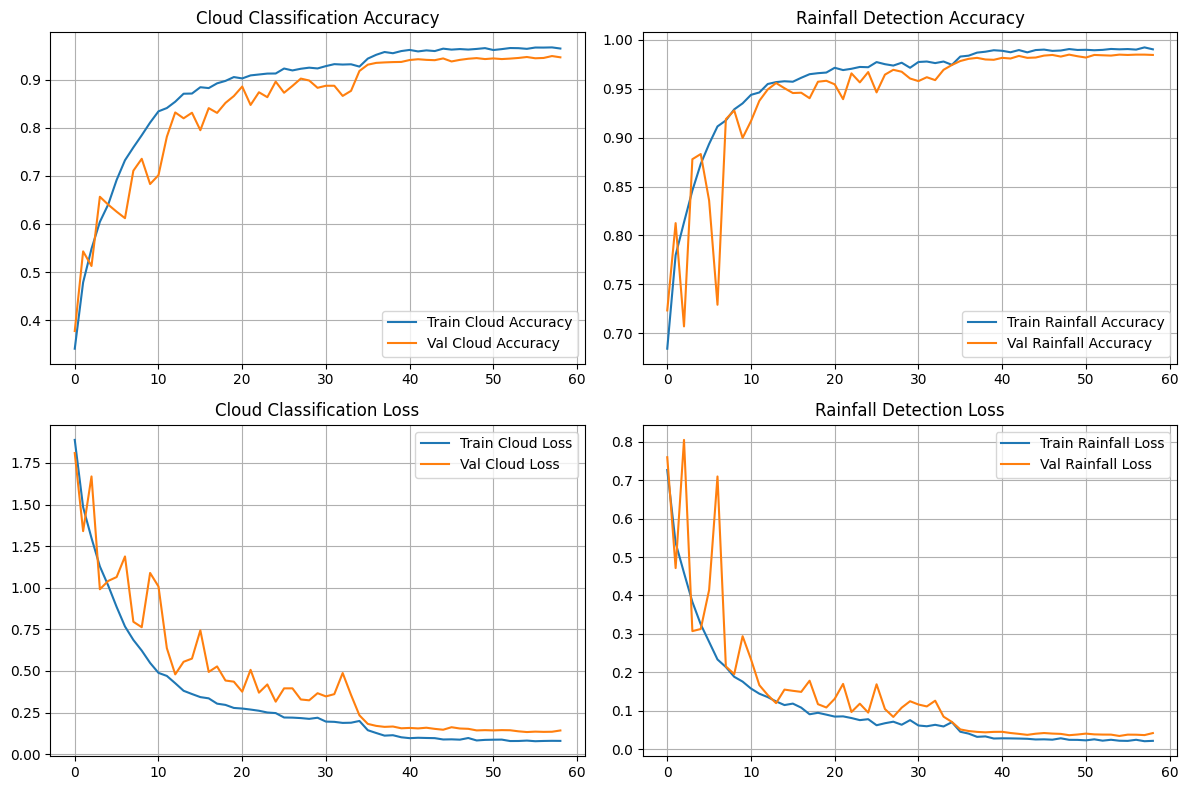

In [10]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pathlib
import random
import gc

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# Clear session and memory
tf.keras.backend.clear_session()
gc.collect()

# Define paths
split_dir = pathlib.Path('./split_dataset')  # Adjust if different
train_dir = split_dir / 'train'
val_dir = split_dir / 'val'
test_dir = split_dir / 'test'

# Rainfall mapping (3 classes, from paper and your Xception code)
rainfall_mapping = {
    'Ci': 0, 'Cs': 0, 'Cc': 0, 'Ac': 0, 'Ct': 0,  # No Rain to Very Low Rain
    'As': 1, 'Sc': 1, 'St': 1, 'Ns': 1,           # Low to Medium Rain
    'Cb': 2, 'Cu': 2                              # Medium to High Rain
}

# Class names (11 classes from CCSN_v2)
class_names = sorted([item.name for item in train_dir.glob('*') if item.is_dir()])
assert len(class_names) == 11, f"Expected 11 cloud classes, found {len(class_names)}"

# Generator for training (with augmentation)
def create_dual_output_generator(directory, batch_size=16):
    datagen = ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
        rotation_range=20,
        horizontal_flip=True,
        vertical_flip=True,
        brightness_range=[0.8, 1.2],
        channel_shift_range=20.0
    )
    generator = datagen.flow_from_directory(
        directory,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True
    )
    while True:
        images, cloud_labels = next(generator)
        rainfall_labels = np.array([rainfall_mapping[class_names[np.argmax(label)]] 
                                   for label in cloud_labels], dtype=np.int32)
        rainfall_labels_onehot = tf.keras.utils.to_categorical(rainfall_labels, num_classes=3)
        yield images, (cloud_labels, rainfall_labels_onehot)

# Generator for validation/test (no augmentation)
def create_val_test_generator(directory, batch_size=16):
    datagen = ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
    )
    generator = datagen.flow_from_directory(
        directory,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )
    while True:
        images, cloud_labels = next(generator)
        rainfall_labels = np.array([rainfall_mapping[class_names[np.argmax(label)]] 
                                   for label in cloud_labels], dtype=np.int32)
        rainfall_labels_onehot = tf.keras.utils.to_categorical(rainfall_labels, num_classes=3)
        yield images, (cloud_labels, rainfall_labels_onehot)

# Dataset sizes (from your previous split)
train_samples = 10678
val_samples = 3051
test_samples = 1526
batch_size = 16

# Create datasets
train_dataset = tf.data.Dataset.from_generator(
    lambda: create_dual_output_generator(train_dir, batch_size),
    output_signature=(
        tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
        (
            tf.TensorSpec(shape=(None, 11), dtype=tf.float32),
            tf.TensorSpec(shape=(None, 3), dtype=tf.float32)
        )
    )
).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_generator(
    lambda: create_val_test_generator(val_dir, batch_size),
    output_signature=(
        tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
        (
            tf.TensorSpec(shape=(None, 11), dtype=tf.float32),
            tf.TensorSpec(shape=(None, 3), dtype=tf.float32)
        )
    )
).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_generator(
    lambda: create_val_test_generator(test_dir, batch_size),
    output_signature=(
        tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
        (
            tf.TensorSpec(shape=(None, 11), dtype=tf.float32),
            tf.TensorSpec(shape=(None, 3), dtype=tf.float32)
        )
    )
).prefetch(tf.data.AUTOTUNE)

# Load MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers[:len(base_model.layers) // 3]:  # Freeze first 1/3
    layer.trainable = False

# Build model with task-specific branches
inputs = layers.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)  # Increased dropout from 0.2 to 0.3, per Xception

# Cloud branch
cloud_x = layers.Dense(128, activation='relu')(x)
cloud_x = layers.Dropout(0.3)(cloud_x)
cloud_output = layers.Dense(11, activation='softmax', name='cloud_output')(cloud_x)

# Rainfall branch
rain_x = layers.Dense(128, activation='relu')(x)
rain_x = layers.Dropout(0.3)(rain_x)
rainfall_output = layers.Dense(3, activation='softmax', name='rainfall_output')(rain_x)

model = models.Model(inputs=inputs, outputs=[cloud_output, rainfall_output])

# Compile
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss={'cloud_output': 'categorical_crossentropy', 'rainfall_output': 'categorical_crossentropy'},
    metrics={'cloud_output': 'accuracy', 'rainfall_output': 'accuracy'}
)

# Model summary
model.summary()

# Training parameters
train_steps = train_samples // batch_size
val_steps = val_samples // batch_size
test_steps = test_samples // batch_size

# Callbacks
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        'best_mobilenetv2_dual.keras',
        monitor='val_rainfall_output_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_rainfall_output_accuracy',
        patience=10,  # Reduced from 20 for faster convergence
        mode='max',
        restore_best_weights=True,
        verbose=1
    )
]

# Initial training
print("Starting initial training...")
history = model.fit(
    train_dataset,
    steps_per_epoch=train_steps,
    epochs=35,  # Matches paper's fine-tuning epochs
    validation_data=val_dataset,
    validation_steps=val_steps,
    callbacks=callbacks,
    verbose=1
)

# Fine-tuning
print("Starting fine-tuning...")
base_model.trainable = True
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),  # Lower LR for fine-tuning
    loss={'cloud_output': 'categorical_crossentropy', 'rainfall_output': 'categorical_crossentropy'},
    metrics={'cloud_output': 'accuracy', 'rainfall_output': 'accuracy'}
)

history_fine = model.fit(
    train_dataset,
    steps_per_epoch=train_steps,
    epochs=35,
    validation_data=val_dataset,
    validation_steps=val_steps,
    callbacks=callbacks,
    verbose=1
)

# Load best model
best_model = tf.keras.models.load_model('best_mobilenetv2_dual.keras')

# Evaluate
test_results = best_model.evaluate(test_dataset, steps=test_steps, return_dict=True)
print("Test Results:")
print(f"Total Loss: {test_results['loss']:.4f}")
print(f"Cloud Loss: {test_results['cloud_output_loss']:.4f}")
print(f"Rainfall Loss: {test_results['rainfall_output_loss']:.4f}")
print(f"Cloud Accuracy: {test_results['cloud_output_accuracy']:.4f}")
print(f"Rainfall Accuracy: {test_results['rainfall_output_accuracy']:.4f}")

# Detailed evaluation
test_dataset_for_eval = test_dataset.take(test_steps)
y_true_cloud = []
y_pred_cloud = []
y_true_rain = []
y_pred_rain = []

for images, (cloud_labels, rainfall_labels) in test_dataset_for_eval:
    predictions = best_model.predict(images)
    cloud_preds = np.argmax(predictions[0], axis=1)
    rain_preds = np.argmax(predictions[1], axis=1)
    y_true_cloud.extend(np.argmax(cloud_labels, axis=1))
    y_pred_cloud.extend(cloud_preds)
    y_true_rain.extend(np.argmax(rainfall_labels, axis=1))
    y_pred_rain.extend(rain_preds)

print("Cloud Classification Report:")
print(classification_report(y_true_cloud, y_pred_cloud, target_names=class_names))
print("Rainfall Detection Report:")
print(classification_report(y_true_rain, y_pred_rain, 
                           target_names=['No Rain to Very Low', 'Low to Medium', 'Medium to High']))

# Confusion matrix for rainfall
cm_rain = confusion_matrix(y_true_rain, y_pred_rain)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rain, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Rain', 'Low-Medium', 'Medium-High'],
            yticklabels=['No Rain', 'Low-Medium', 'Medium-High'])
plt.title('Rainfall Prediction Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Plotting
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(history.history['cloud_output_accuracy'] + history_fine.history['cloud_output_accuracy'], label='Train Cloud Accuracy')
plt.plot(history.history['val_cloud_output_accuracy'] + history_fine.history['val_cloud_output_accuracy'], label='Val Cloud Accuracy')
plt.title('Cloud Classification Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(history.history['rainfall_output_accuracy'] + history_fine.history['rainfall_output_accuracy'], label='Train Rainfall Accuracy')
plt.plot(history.history['val_rainfall_output_accuracy'] + history_fine.history['val_rainfall_output_accuracy'], label='Val Rainfall Accuracy')
plt.title('Rainfall Detection Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(history.history['cloud_output_loss'] + history_fine.history['cloud_output_loss'], label='Train Cloud Loss')
plt.plot(history.history['val_cloud_output_loss'] + history_fine.history['val_cloud_output_loss'], label='Val Cloud Loss')
plt.title('Cloud Classification Loss')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(history.history['rainfall_output_loss'] + history_fine.history['rainfall_output_loss'], label='Train Rainfall Loss')
plt.plot(history.history['val_rainfall_output_loss'] + history_fine.history['val_rainfall_output_loss'], label='Val Rainfall Loss')
plt.title('Rainfall Detection Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Memory cleanup
gc.collect()
tf.keras.backend.clear_session()

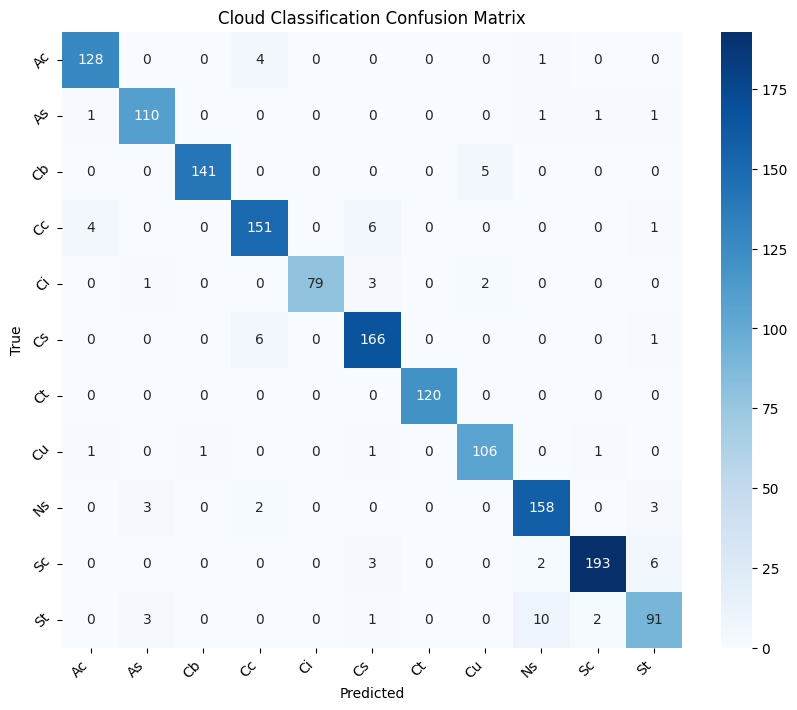

In [11]:
from sklearn.metrics import confusion_matrix

# Confusion matrix for cloud classification
cm_cloud = confusion_matrix(y_true_cloud, y_pred_cloud)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_cloud, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Cloud Classification Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=45)
plt.show()


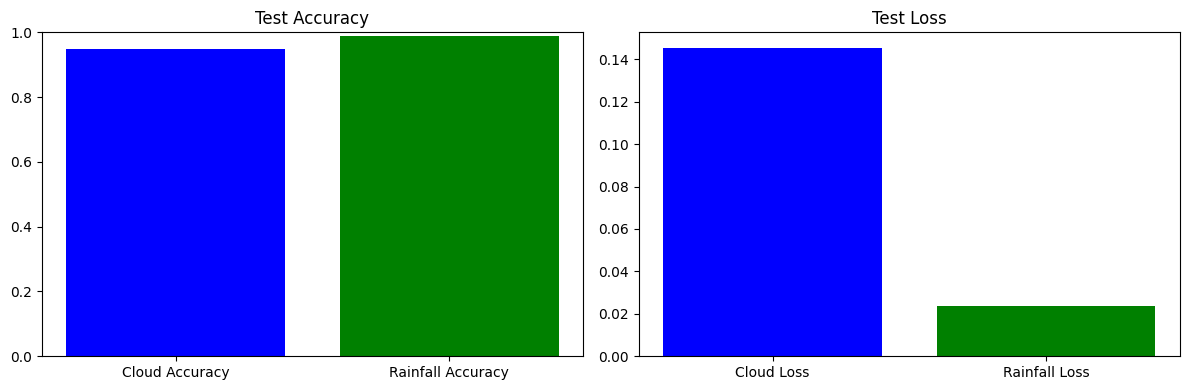

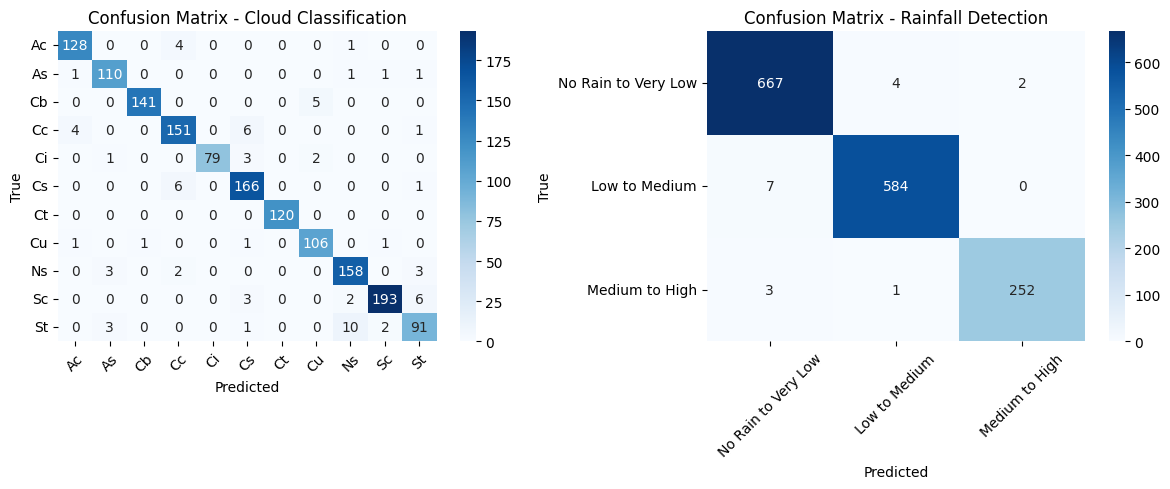

Cloud Classification Report:
              precision    recall  f1-score   support

          Ac       0.96      0.96      0.96       133
          As       0.94      0.96      0.95       114
          Cb       0.99      0.97      0.98       146
          Cc       0.93      0.93      0.93       162
          Ci       1.00      0.93      0.96        85
          Cs       0.92      0.96      0.94       173
          Ct       1.00      1.00      1.00       120
          Cu       0.94      0.96      0.95       110
          Ns       0.92      0.95      0.93       166
          Sc       0.98      0.95      0.96       204
          St       0.88      0.85      0.87       107

    accuracy                           0.95      1520
   macro avg       0.95      0.95      0.95      1520
weighted avg       0.95      0.95      0.95      1520


Rainfall Detection Report:
                     precision    recall  f1-score   support

No Rain to Very Low       0.99      0.99      0.99       673
      L

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import json

# Bar Plots for Accuracy and Loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.bar(['Cloud Accuracy', 'Rainfall Accuracy'], 
        [test_results['cloud_output_accuracy'], test_results['rainfall_output_accuracy']], 
        color=['blue', 'green'])
plt.title('Test Accuracy')
plt.ylim(0, 1)

plt.subplot(1, 2, 2)
plt.bar(['Cloud Loss', 'Rainfall Loss'], 
        [test_results['cloud_output_loss'], test_results['rainfall_output_loss']], 
        color=['blue', 'green'])
plt.title('Test Loss')
plt.tight_layout()
plt.show()

# Confusion Matrices
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
cm_cloud = confusion_matrix(y_true_cloud, y_pred_cloud)
sns.heatmap(cm_cloud, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - Cloud Classification')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45)
plt.yticks(rotation=0)

plt.subplot(1, 2, 2)
cm_rain = confusion_matrix(y_true_rain, y_pred_rain)
rain_labels = ['No Rain to Very Low', 'Low to Medium', 'Medium to High']
sns.heatmap(cm_rain, annot=True, fmt='d', cmap='Blues', 
            xticklabels=rain_labels, yticklabels=rain_labels)
plt.title('Confusion Matrix - Rainfall Detection')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Classification Reports
print("Cloud Classification Report:")
print(classification_report(y_true_cloud, y_pred_cloud, target_names=class_names))
print("\nRainfall Detection Report:")
print(classification_report(y_true_rain, y_pred_rain, target_names=rain_labels))

# Visualization of Sample Predictions
def plot_class_predictions(class_idx, class_name, num_examples=5):
    class_indices = np.where(y_true_cloud == class_idx)[0]
    if len(class_indices) == 0:
        print(f"No true instances of {class_name} found in test data.")
        return
    selected_indices = np.random.choice(class_indices, min(num_examples, len(class_indices)), replace=False)
    plt.figure(figsize=(15, 3))
    for i, idx in enumerate(selected_indices):
        img = test_images[idx] * 127.5 + 127.5  # Undo preprocessing
        img = np.clip(img, 0, 255).astype(np.uint8)
        plt.subplot(1, num_examples, i + 1)
        plt.imshow(img)
        true_cloud = class_names[y_true_cloud[idx]]
        pred_cloud = class_names[y_pred_cloud[idx]]
        true_rain = rain_labels[y_true_rain[idx]]
        pred_rain = rain_labels[y_pred_rain[idx]]
        plt.title(f"True: {true_cloud} ({true_rain})\nPred: {pred_cloud} ({pred_rain})")
        plt.axis('off')
    plt.suptitle(f"Predictions for Class: {class_name}")
    plt.tight_layout()
    plt.show()


In [25]:
model.save("MobileNetV2.h5")

In [29]:
from IPython.display import FileLink

# Replace with the correct file name if different
FileLink('/kaggle/working/best_mobilenetv2_dual.keras')


/kaggle/working/best_mobilenetv2_dual.keras